In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
# Define the path to your financial reports directory
financial_reports_path = "/Users/kdn_aigayatrikadam/Desktop/Projects/Project-5/AI Powered financial reporting/backend/data_processing/financial_reports"

# List files in the directory
print("Available files in financial_reports folder:")
print(os.listdir(financial_reports_path))


Available files in financial_reports folder:
['AMZN_cash_flow.csv', 'MSFT_cash_flow.csv', 'AAPL_cash_flow.csv', 'MSFT_income_statement.csv', 'TSLA_income_statement.csv', 'V_balance_sheet.csv', 'GOOGL_cash_flow.csv', 'TSLA_balance_sheet.csv', '.DS_Store', 'META_income_statement.csv', 'NVDA_balance_sheet.csv', 'GOOGL_income_statement.csv', 'NVDA_cash_flow.csv', 'cleaned', 'AMZN_balance_sheet.csv', 'META_balance_sheet.csv', 'IBM_income_statement.csv', 'GOOGL_balance_sheet.csv', 'NVDA_income_statement.csv', 'AMZN_income_statement.csv', 'META_cash_flow.csv', 'AAPL_income_statement.csv', 'MSFT_balance_sheet.csv', 'JPM_balance_sheet.csv', 'IBM_cash_flow.csv', 'V_income_statement.csv', 'V_cash_flow.csv', 'JPM_income_statement.csv', 'JPM_cash_flow.csv', 'TSLA_cash_flow.csv', 'AAPL_balance_sheet.csv', 'IBM_balance_sheet.csv']


In [3]:
# Define the path to the cleaned financial reports directory
cleaned_path = "/Users/kdn_aigayatrikadam/Desktop/Projects/Project-5/AI Powered financial reporting/backend/data_processing/financial_reports/cleaned"

# Get the list of available companies by extracting unique symbols from filenames
cleaned_files = os.listdir(cleaned_path)
companies = list(set([file.split("_")[0] for file in cleaned_files]))

# Dictionary to store data for each company
company_data = {}

# Load cleaned financial statements for each company
for company in companies:
    try:
        balance_sheet = pd.read_csv(f"{cleaned_path}/{company}_balance_sheet_cleaned.csv")
        income_statement = pd.read_csv(f"{cleaned_path}/{company}_income_statement_cleaned.csv")
        cash_flow = pd.read_csv(f"{cleaned_path}/{company}_cash_flow_cleaned.csv")

        # Convert "year" column to datetime format for sorting
        balance_sheet["year"] = pd.to_datetime(balance_sheet["year"])
        income_statement["year"] = pd.to_datetime(income_statement["year"])
        cash_flow["year"] = pd.to_datetime(cash_flow["year"])

        # Merge datasets on "year" column
        df = balance_sheet.merge(income_statement, on=["year", "symbol", "reportedcurrency"], how="inner")
        df = df.merge(cash_flow, on=["year", "symbol", "reportedcurrency"], how="inner")

        # Sort data by year
        df = df.sort_values("year").reset_index(drop=True)

        # Store the merged dataframe for each company
        company_data[company] = df

        print(f"✅ {company} data loaded successfully!")

    except Exception as e:
        print(f"⚠️ Error loading data for {company}: {e}")

# Display first company’s data as a preview
first_company = list(company_data.keys())[0]
print(f"\nSample data for {first_company}:")
print(company_data[first_company].head())


✅ META data loaded successfully!
✅ JPM data loaded successfully!
✅ AMZN data loaded successfully!
✅ GOOGL data loaded successfully!
✅ AAPL data loaded successfully!
✅ MSFT data loaded successfully!
✅ NVDA data loaded successfully!
✅ IBM data loaded successfully!
✅ V data loaded successfully!
✅ TSLA data loaded successfully!

Sample data for META:
        year  reportedcurrency  totalassets  totalcurrentassets  \
0 2012-12-31               0.0  15103000000         11267000000   
1 2013-12-31               0.0  17895000000         13070000000   
2 2014-12-31               0.0  39966000000         13390000000   
3 2015-12-31               0.0  49407000000         21652000000   
4 2016-12-31               0.0  64961000000         34401000000   

   cashandcashequivalentsatcarryingvalue  cashandshortterminvestments  \
0                             2384000000                   9626000000   
1                             3323000000                  11449000000   
2                            

In [4]:
# Dictionary to store available years for each company
company_years = {}

# Iterate through loaded data
for company, df in company_data.items():
    if "year" in df.columns:
        available_years = sorted(df["year"].dt.year.unique())
        company_years[company] = available_years

# Print available years for each company
for company, years in company_years.items():
    print(f"{company}: {years}")


META: [np.int32(2012), np.int32(2013), np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]
JPM: [np.int32(2009), np.int32(2010), np.int32(2011), np.int32(2012), np.int32(2013), np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
AMZN: [np.int32(2009), np.int32(2010), np.int32(2011), np.int32(2012), np.int32(2013), np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]
GOOGL: [np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]
AAPL: [np.int32(2009), np.int32(2010), np.int32(2011), np.int32(2012), np.int32(2013), np.int32(2014), np.in

In [5]:
# Target years (last 16 years)
target_years = list(range(2009, 2025))

# Trim each company's dataset to the target years
for company, df in company_data.items():
    df["year"] = df["year"].dt.year  # Convert to integer for filtering
    df = df[df["year"].isin(target_years)].reset_index(drop=True)
    company_data[company] = df  # Update the stored dataset

    print(f"✅ {company} data trimmed to 16 years (2009–2024)")

print("\nAll datasets are now consistent with 16 years of data!")


✅ META data trimmed to 16 years (2009–2024)
✅ JPM data trimmed to 16 years (2009–2024)
✅ AMZN data trimmed to 16 years (2009–2024)
✅ GOOGL data trimmed to 16 years (2009–2024)
✅ AAPL data trimmed to 16 years (2009–2024)
✅ MSFT data trimmed to 16 years (2009–2024)
✅ NVDA data trimmed to 16 years (2009–2024)
✅ IBM data trimmed to 16 years (2009–2024)
✅ V data trimmed to 16 years (2009–2024)
✅ TSLA data trimmed to 16 years (2009–2024)

All datasets are now consistent with 16 years of data!


In [9]:
# Define the required columns for each dataset
balance_sheet_cols = [
    "year", "totalcurrentassets", "totalnoncurrentassets",
    "totalcurrentliabilities", "totalnoncurrentliabilities", "totalshareholderequity"
]
income_statement_cols = [
    "year", "totalrevenue", "grossprofit", "operatingincome", "netincome"
]
cash_flow_cols = [
    "year", "operatingcashflow", "capitalexpenditures", "cashflowfromfinancing"
]

# Dictionary to store processed data for each company
processed_data = {}

# Process each company's dataset
for company, df in company_data.items():
    try:
        # Select only relevant columns
        balance_sheet = df[balance_sheet_cols]
        income_statement = df[income_statement_cols]
        cash_flow = df[cash_flow_cols]

        # Merge datasets on "year"
        merged_data = balance_sheet.merge(income_statement, on="year").merge(cash_flow, on="year")

        # Sort by year
        merged_data = merged_data.sort_values(by="year").reset_index(drop=True)

        # Store the processed data
        processed_data[company] = merged_data

        print(f"✅ {company} data processed successfully!")

    except Exception as e:
        print(f"⚠️ Error processing data for {company}: {e}")

# Display first company's processed data as a preview
first_company = list(processed_data.keys())[0]
print(f"\nSample processed data for {first_company}:")
print(processed_data[first_company].head())


⚠️ Error processing data for META: "['netincome'] not in index"
⚠️ Error processing data for JPM: "['netincome'] not in index"
⚠️ Error processing data for AMZN: "['netincome'] not in index"
⚠️ Error processing data for GOOGL: "['netincome'] not in index"
⚠️ Error processing data for AAPL: "['netincome'] not in index"
⚠️ Error processing data for MSFT: "['netincome'] not in index"
⚠️ Error processing data for NVDA: "['netincome'] not in index"
⚠️ Error processing data for IBM: "['netincome'] not in index"
⚠️ Error processing data for V: "['netincome'] not in index"
⚠️ Error processing data for TSLA: "['netincome'] not in index"


IndexError: list index out of range

In [10]:
# Check available columns in each dataset
for company, df in company_data.items():
    print(f"\n🔍 {company} - Available Columns:")
    print(df.columns.tolist())



🔍 META - Available Columns:
['year', 'reportedcurrency', 'totalassets', 'totalcurrentassets', 'cashandcashequivalentsatcarryingvalue', 'cashandshortterminvestments', 'inventory', 'currentnetreceivables', 'totalnoncurrentassets', 'propertyplantequipment', 'accumulateddepreciationamortizationppe', 'intangibleassets', 'intangibleassetsexcludinggoodwill', 'goodwill', 'investments', 'longterminvestments', 'shortterminvestments', 'othercurrentassets', 'othernoncurrentassets', 'totalliabilities', 'totalcurrentliabilities', 'currentaccountspayable', 'deferredrevenue', 'currentdebt', 'shorttermdebt', 'totalnoncurrentliabilities', 'capitalleaseobligations', 'longtermdebt', 'currentlongtermdebt', 'longtermdebtnoncurrent', 'shortlongtermdebttotal', 'othercurrentliabilities', 'othernoncurrentliabilities', 'totalshareholderequity', 'treasurystock', 'retainedearnings', 'commonstock', 'commonstocksharesoutstanding', 'symbol', 'grossprofit', 'totalrevenue', 'costofrevenue', 'costofgoodsandservicessold

In [14]:
# Define the required columns for each dataset
balance_sheet_cols = [
    "year", "totalcurrentassets", "totalnoncurrentassets",
    "totalcurrentliabilities", "totalnoncurrentliabilities", "totalshareholderequity"
]
income_statement_cols = [
    "year", "totalrevenue", "grossprofit", "operatingincome"
]
cash_flow_cols = [
    "year", "operatingcashflow", "capitalexpenditures", "cashflowfromfinancing"
]

# Dictionary to store processed data for each company
processed_data = {}

# Process each company's dataset
for company, df in company_data.items():
    try:
        # Select only relevant columns
        balance_sheet = df[balance_sheet_cols]
        income_statement = df[income_statement_cols]
        cash_flow = df[cash_flow_cols]

        # Identify the correct 'netincome' column dynamically
        netincome_col = None
        for col in df.columns:
            if "netincome" in col.lower().replace("_", "").replace(" ", ""):
                netincome_col = col
                break  # Take the first match

        if netincome_col:
            print(f"✅ Using '{netincome_col}' for {company}")
            income_statement[netincome_col] = df[netincome_col]
        else:
            print(f"⚠️ Warning: 'netincome' column not found for {company}, skipping it.")

        # Merge datasets on "year"
        merged_data = balance_sheet.merge(income_statement, on="year", how="left").merge(
            cash_flow, on="year", how="left"
        )

        # Sort by year
        merged_data = merged_data.sort_values(by="year").reset_index(drop=True)

        # Store the processed data
        processed_data[company] = merged_data

        print(f"✅ {company} data processed successfully!")

    except Exception as e:
        print(f"⚠️ Error processing data for {company}: {e}")

# Display first company's processed data as a preview
first_company = list(processed_data.keys())[0]
print(f"\nSample processed data for {first_company}:")
print(processed_data[first_company].head())


✅ Using 'netincomefromcontinuingoperations' for META
✅ META data processed successfully!
✅ Using 'netincomefromcontinuingoperations' for JPM
✅ JPM data processed successfully!
✅ Using 'netincomefromcontinuingoperations' for AMZN
✅ AMZN data processed successfully!
✅ Using 'netincomefromcontinuingoperations' for GOOGL
✅ GOOGL data processed successfully!
✅ Using 'netincomefromcontinuingoperations' for AAPL
✅ AAPL data processed successfully!
✅ Using 'netincomefromcontinuingoperations' for MSFT
✅ MSFT data processed successfully!
✅ Using 'netincomefromcontinuingoperations' for NVDA
✅ NVDA data processed successfully!
✅ Using 'netincomefromcontinuingoperations' for IBM
✅ IBM data processed successfully!
✅ Using 'netincomefromcontinuingoperations' for V
✅ V data processed successfully!
✅ Using 'netincomefromcontinuingoperations' for TSLA
✅ TSLA data processed successfully!

Sample processed data for META:
   year  totalcurrentassets  totalnoncurrentassets  totalcurrentliabilities  \
0  201

/var/folders/x4/v6hvdyyn1c71vrsjglz365j00000gn/T/ipykernel_7517/1709808353.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_statement[netincome_col] = df[netincome_col]
/var/folders/x4/v6hvdyyn1c71vrsjglz365j00000gn/T/ipykernel_7517/1709808353.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_statement[netincome_col] = df[netincome_col]
/var/folders/x4/v6hvdyyn1c71vrsjglz365j00000gn/T/ipykernel_7517/1709808353.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [15]:
# Dictionary to store processed data for each company
processed_data = {}

# Process each company's dataset
for company, df in company_data.items():
    try:
        # Select only relevant columns
        balance_sheet = df[balance_sheet_cols]
        income_statement = df[income_statement_cols]
        cash_flow = df[cash_flow_cols]

        # Identify the correct 'netincome' column dynamically
        netincome_col = None
        for col in df.columns:
            if "netincome" in col.lower().replace("_", "").replace(" ", ""):
                netincome_col = col
                break  # Take the first match

        if netincome_col:
            print(f"✅ Using '{netincome_col}' for {company}")

            # Fix: Ensure we modify a copy of the DataFrame
            income_statement = income_statement.copy()
            income_statement.loc[:, netincome_col] = df[netincome_col].values
        else:
            print(f"⚠️ Warning: 'netincome' column not found for {company}, skipping it.")

        # Merge datasets on "year"
        merged_data = balance_sheet.merge(income_statement, on="year", how="left").merge(
            cash_flow, on="year", how="left"
        )

        # Sort by year
        merged_data = merged_data.sort_values(by="year").reset_index(drop=True)

        # Store the processed data
        processed_data[company] = merged_data

        print(f"✅ {company} data processed successfully!")

    except Exception as e:
        print(f"⚠️ Error processing data for {company}: {e}")

# Display first company's processed data as a preview
first_company = list(processed_data.keys())[0]
print(f"\nSample processed data for {first_company}:")
print(processed_data[first_company].head())


✅ Using 'netincomefromcontinuingoperations' for META
✅ META data processed successfully!
✅ Using 'netincomefromcontinuingoperations' for JPM
✅ JPM data processed successfully!
✅ Using 'netincomefromcontinuingoperations' for AMZN
✅ AMZN data processed successfully!
✅ Using 'netincomefromcontinuingoperations' for GOOGL
✅ GOOGL data processed successfully!
✅ Using 'netincomefromcontinuingoperations' for AAPL
✅ AAPL data processed successfully!
✅ Using 'netincomefromcontinuingoperations' for MSFT
✅ MSFT data processed successfully!
✅ Using 'netincomefromcontinuingoperations' for NVDA
✅ NVDA data processed successfully!
✅ Using 'netincomefromcontinuingoperations' for IBM
✅ IBM data processed successfully!
✅ Using 'netincomefromcontinuingoperations' for V
✅ V data processed successfully!
✅ Using 'netincomefromcontinuingoperations' for TSLA
✅ TSLA data processed successfully!

Sample processed data for META:
   year  totalcurrentassets  totalnoncurrentassets  totalcurrentliabilities  \
0  201

In [16]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split

# Initialize scaler
scaler = MinMaxScaler()

# Target variable for prediction
target_col = "totalrevenue"
SEQ_LENGTH = 5  # Number of time steps for LSTM sequences

# Store training and testing data
X_all, y_all = [], []

# Process each company's data
for company, df in processed_data.items():
    try:
        # Convert year to numeric format
        df["year"] = pd.to_numeric(df["year"], errors="coerce")

        # Select only numeric columns for scaling
        numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
        numeric_cols.remove("year")  # Don't scale the year column

        # Apply MinMax scaling
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

        # Ensure target column exists
        if target_col not in df.columns:
            print(f"⚠️ Warning: {target_col} not found for {company}, skipping.")
            continue

        # Convert target column to numpy array
        company_data = df[target_col].values.reshape(-1, 1)

        # Create sequences for LSTM
        def create_sequences(data, seq_length):
            X, y = [], []
            for i in range(len(data) - seq_length):
                X.append(data[i:i+seq_length])
                y.append(data[i+seq_length])
            return np.array(X), np.array(y)

        X, y = create_sequences(company_data, SEQ_LENGTH)
        X_all.append(X)
        y_all.append(y)

        print(f"✅ Sequences created for {company}")

    except Exception as e:
        print(f"⚠️ Error processing sequences for {company}: {e}")

# Combine all companies' data
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)

print(f"✅ Data ready for LSTM training: {X_train.shape} training samples, {X_test.shape} test samples")


✅ Sequences created for META
✅ Sequences created for JPM
✅ Sequences created for AMZN
✅ Sequences created for GOOGL
✅ Sequences created for AAPL
✅ Sequences created for MSFT
✅ Sequences created for NVDA
✅ Sequences created for IBM
✅ Sequences created for V
✅ Sequences created for TSLA
✅ Data ready for LSTM training: (75, 5, 1) training samples, (19, 5, 1) test samples


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, 1)),  
    LSTM(50, activation='relu'),
    Dense(1)  # Output layer for predicting total revenue
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
EPOCHS = 50
BATCH_SIZE = 8

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

print("✅ Model training complete!")


Epoch 1/50


/Users/kdn_aigayatrikadam/Desktop/Projects/Project-5/AI Powered financial reporting/env-financial-reporting/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2863 - val_loss: 0.3256
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2384 - val_loss: 0.2668
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1846 - val_loss: 0.1811
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1025 - val_loss: 0.0698
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0580 - val_loss: 0.0403
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0662 - val_loss: 0.0543
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0646 - val_loss: 0.0536
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0702 - val_loss: 0.0519
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0616 - val_loss: 0.0445
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0612 - val_loss: 0.0445
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0623 - val_loss: 0.0511
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0608 - val_loss: 0.0427

In [23]:
# Ensure we inverse transform only the target column
if 'scaler' in globals():
    # Get number of features from scaler
    num_features = scaler.scale_.shape[0]

    # Pad y_test and y_pred to match num_features
    padding_test = np.zeros((y_test.shape[0], num_features - 1))  # Exclude the target column
    y_test_padded = np.concatenate((y_test, padding_test), axis=1)

    padding_pred = np.zeros((y_pred.shape[0], num_features - 1))
    y_pred_padded = np.concatenate((y_pred, padding_pred), axis=1)

    # Inverse transform and extract the target column
    y_test_original = scaler.inverse_transform(y_test_padded)[:, 0]
    y_pred_original = scaler.inverse_transform(y_pred_padded)[:, 0]
else:
    y_test_original = y_test
    y_pred_original = y_pred


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate error metrics
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f"📉 Mean Squared Error (MSE): {mse:.2f}")
print(f"📊 Mean Absolute Error (MAE): {mae:.2f}")
print(f"📈 R² Score: {r2:.4f}")


📉 Mean Squared Error (MSE): 43157965783336894464.00
📊 Mean Absolute Error (MAE): 5147747301.55
📈 R² Score: 0.8552


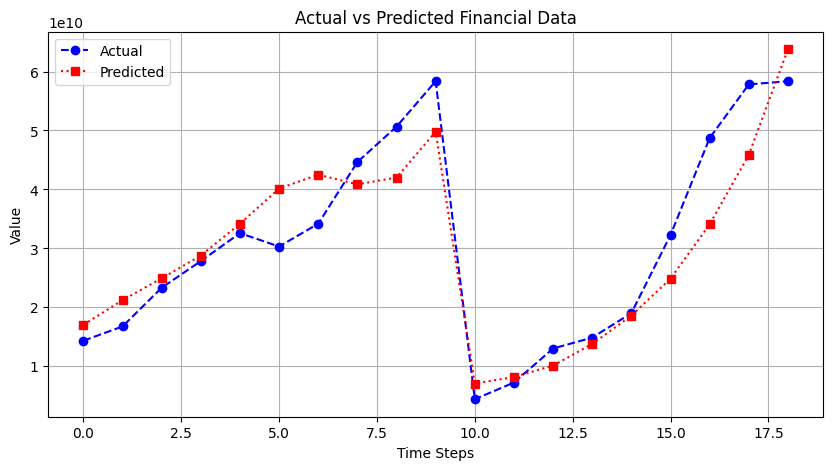

In [25]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_original, label="Actual", marker='o', linestyle='dashed', color='blue')
plt.plot(y_pred_original, label="Predicted", marker='s', linestyle='dotted', color='red')
plt.title("Actual vs Predicted Financial Data")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()
